In [1]:
import SimPEG as simpeg
from SimPEG import maps, utils
import discretize
from discretize.utils import mkvc, refine_tree_xyz
from SimPEG.electromagnetics import natural_source as ns
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver


(1764, 3)


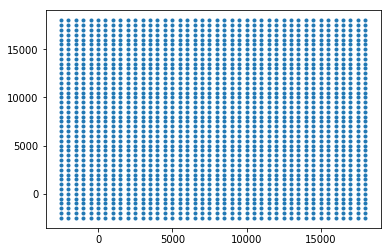

In [2]:
rx_x, rx_y = np.meshgrid(np.arange(-2500, 18500, 500), np.arange(-2500, 18500, 500))
# print(rx_x, rx_y)
rx_loc = np.hstack((mkvc(rx_x, 2), mkvc(rx_y, 2), np.zeros((np.prod(rx_x.shape), 1))))
midx = -2500.0 - 48258
midy = -2500.0 - 48258
print(rx_loc.shape)

plt.plot(rx_loc[:, 0], rx_loc[:, 1], '.')
plt.show()

In [4]:
# create Mesh
mesh = discretize.TensorMesh(
[
    [(1000, 7, -1.5), (500., 40), (1000, 7, 1.5)],
    [(1000, 7, -1.5), (500., 40), (1000, 7, 1.5)],
    [(500, 7, -1.6), (250., 40), (500, 3, 2)]
])
mesh.x0 = [midx, midy, -44458.061]

# ===================================================================================================================
# for when Octree-tree is usuable

# print(meshInput.x0)

# padLen = 800
# octreeObs = [17, 5, 5]
# octreeTopo = [5, 2, 1]
# h = [meshInput.hx.min(), meshInput.hy.min(), meshInput.hy.min()]
# # h = [25, 25, 25]
# print(h)
# padDist = np.r_[np.c_[padLen, padLen], np.c_[padLen, padLen], np.c_[padLen, 0]]
# # padDist = np.ones((3,2)) * 400.
# # padDist[2, 0] = 0
# # padDist[2, 1] = 0
# print(padDist)
# mesh = meshBuilder(rx_loc, h, padDist,
#                    meshType='TREE', meshGlobal=meshInput,
#                    verticalAlignment='top')
# # Refine the mesh around topographyttb
# # mesh = refineTree(mesh, rx_loc, dtype='surface',
# #                   nCpad=[0, 0, 1, 1], finalize=False)

# # Refine the mesh around topographyttb
# mesh = refineTree(mesh, rx_loc, dtype='surface',
#                   nCpad=[15, 10, 5], finalize=True)
# ====================================================================================================================
 
block_1 = utils.ModelBuilder.getIndicesBlock([3500, 10000, -1000], [11000, 12000, -2000], mesh.gridCC)[0].tolist() # Porphyry Intrusion
block_2 = utils.ModelBuilder.getIndicesBlock([9000, 3000, -1000], [11000, 12000, -2000], mesh.gridCC)[0].tolist() # Porphyry Intrusion
active = mesh.gridCC[:, 2] < 50
sig = np.ones(mesh.nC) * 0.01
## COMMENT FOR PORPHYRY MODEL
sig[block_1] = 1
sig[block_2] = 1
sig[~active] = 1e-8
model_true = np.log(sig)

print(model_true.shape)

rx_loc[:, 2] = 50

# Make a receiver list
rxList = []
for rx_orientation in ['xx', 'xy', 'yx', 'yy']:
    rxList.append(ns.Rx.Point_impedance3D(rx_loc, rx_orientation, 'real'))
    rxList.append(ns.Rx.Point_impedance3D(rx_loc, rx_orientation, 'imag'))
# for rx_orientation in ['zx', 'zy']:
#     rxList.append(NSEM.Rx.Point_tipper3D(rx_loc, rx_orientation, 'real'))
#     rxList.append(NSEM.Rx.Point_tipper3D(rx_loc, rx_orientation, 'imag'))

# Source list
srcList = [
    ns.Src.Planewave_xy_1Dprimary(rxList, freq)
    for freq in [10, 50, 200]
]

# Survey MT
survey = ns.Survey(srcList)
survey.m_true = model_true

# survey_mt.drapeTopo(mesh, actinds, option='top')                       # drape topo

(145800,)


In [4]:
# write out the true model
discretize.TensorMesh.writeUBC(mesh,'Mesh-pre.msh', models={'Sigma-pre.dat': np.exp(model_true)})

In [5]:
# create background conductivity model
sigBG = np.zeros(mesh.nC) + 1/100.
sigBG[~active] = 1e-8

# Set the mapping
actMap = maps.InjectActiveCells(
    mesh=mesh, indActive=active, valInactive=np.log(1e-8))
mapping = maps.ExpMap(mesh) * actMap

# Setup the problem object
sim = ns.simulation.Problem3D_ePrimSec(mesh, survey=survey,
                                           sigmaPrimary=sigBG,
                                           sigmaMap=mapping,
                                           solver=Solver)

sim.model = sigBG[active]
fields = sim.fields()
sim.survey.dtrue = sim.dpred(model_true[active])
# create observations
sim.survey.dobs = (survey.dtrue + 0.05 * abs(sim.survey.dtrue))

# Assign uncertainties
std = 0.05  # 5% std
sim.survey.std = np.abs(survey.dobs * std) + 10**(-4.2)
# make data object
fwd_data = simpeg.Data(sim.survey)


C:\ProgramData\Anaconda3\lib\site-packages\simpeg-0.12.0-py3.7.egg\SimPEG\survey.py:79: UserWarning: BaseRx.locs will be deprecaited and replaced with BaseRx.locations. Please update your code accordingly
C:\ProgramData\Anaconda3\lib\site-packages\simpeg-0.12.0-py3.7.egg\SimPEG\electromagnetics\frequency_domain\sources.py:36: UserWarning: The freq property will be depreciated in favor of frequency. Please update your code accordingly


In [20]:
# assign different weights to individual components - will need to turn this nice little general method
num_station = rx_loc.shape[0]
sim.survey.std = np.abs(survey.dobs * std) + 10**(-3.5)
num_sets = int(sim.survey.dobs.shape[0] / 3)
dnew = np.reshape(sim.survey.dobs, (3, num_sets))
stdnew = np.reshape(sim.survey.std, (3, num_sets))
stdnew[0, num_station*2:num_station*3] = np.abs(dnew[0, num_station*2:num_station*3] * std) + 10**(-3.5)
stdnew[1, num_station*2:num_station*3] = np.abs(dnew[1, num_station*2:num_station*3] * std) + 10**(-4.5)
stdnew[2, num_station*2:num_station*3] = np.abs(dnew[2, num_station*2:num_station*3] * std) + 10**(-4.5)
stdnew[0, num_station*3:num_station*4] = np.abs(dnew[0, num_station*3:num_station*4] * std) + 10**(-3.5)
stdnew[1, num_station*3:num_station*4] = np.abs(dnew[1, num_station*3:num_station*4] * std) + 10**(-4.5)
stdnew[2, num_station*3:num_station*4] = np.abs(dnew[2, num_station*3:num_station*4] * std) + 10**(-4.5)
stdnew[0, num_station*4:num_station*5] = np.abs(dnew[0, num_station*4:num_station*5] * std) + 10**(-3.5)
stdnew[1, num_station*4:num_station*5] = np.abs(dnew[1, num_station*4:num_station*5] * std) + 10**(-4.5)
stdnew[2, num_station*4:num_station*5] = np.abs(dnew[2, num_station*4:num_station*5] * std) + 10**(-4.5)
stdnew[0, num_station*5:num_station*6] = np.abs(dnew[0, num_station*5:num_station*6] * std) + 10**(-3.5)
stdnew[1, num_station*5:num_station*6] = np.abs(dnew[1, num_station*5:num_station*6] * std) + 10**(-4.5)
stdnew[2, num_station*5:num_station*6] = np.abs(dnew[2, num_station*5:num_station*6] * std) + 10**(-4.5)
stdnew = np.reshape(stdnew, (sim.survey.dobs.shape[0]))
sim.survey.std = stdnew
# Assign the data weight
Wd = 1. / sim.survey.std

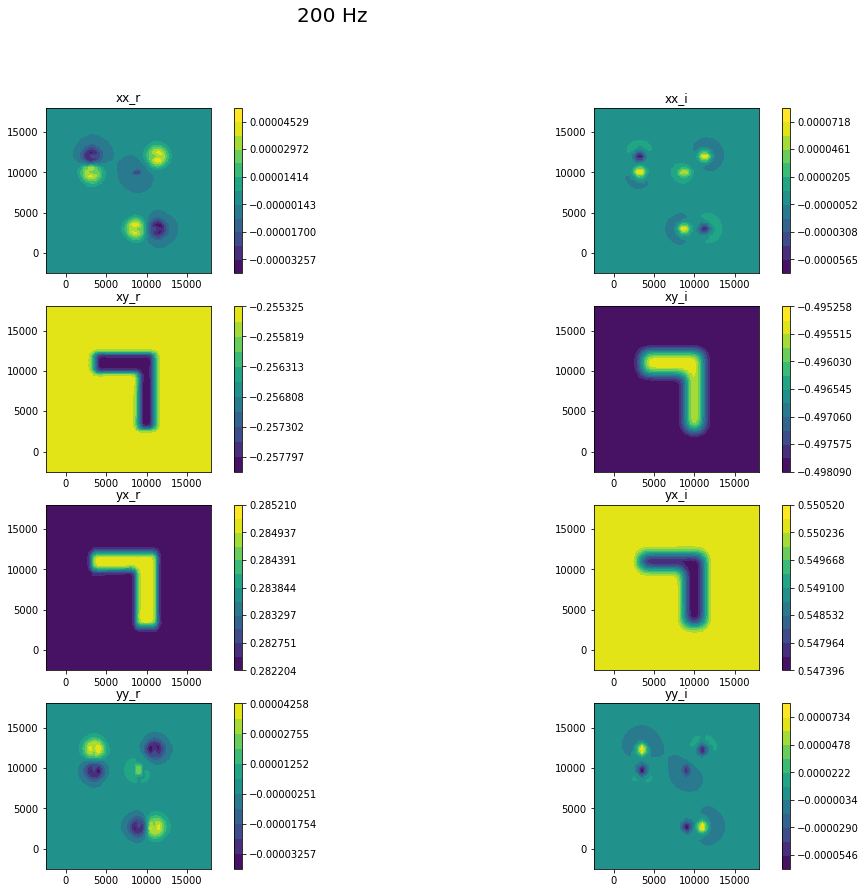

In [19]:
# reshape data for plotting
num_sets = int(survey.dobs.shape[0] / 3.)
dnew = np.reshape(survey.dobs, (3, num_sets))
freqs = ['10', '50', '200']
cnt = 2
cnt_comp = 0
comps_ = ['xx_r', 'xx_i', 'xy_r', 'xy_i', 'yx_r', 'yx_i', 'yy_r', 'yy_i']
fig1 = plt.figure(figsize=(18, 14))
for rx_orientation in range(len(comps_)):
    ax = plt.subplot(4,2, cnt_comp + 1)
    im = simpeg.utils.PlotUtils.plot2Ddata(rx_loc, dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)], ax=ax)
    ax.set_title(comps_[rx_orientation])
    plt.colorbar(im[0])
    cnt_comp += 1
fig1.suptitle(freqs[cnt] + ' Hz', fontsize='20')
plt.show()

In [21]:
fwd_data.dobs = sim.survey.dobs
fwd_data.standard_deviation = sim.survey.std

In [22]:
# Setup the inversion proceedure
# Define a counter
C = simpeg.utils.Counter()
# Optimization
opt = simpeg.optimization.ProjectedGNCG(maxIter=15, upper=np.inf, lower=-np.inf)
opt.counter = C
opt.maxIterCG = 20
# opt.LSshorten = 0.5
opt.remember('xc')
# Data misfit
dmis = simpeg.data_misfit.L2DataMisfit(data=fwd_data, simulation=sim)
dmis.W = Wd
# Regularization
regmap = simpeg.maps.IdentityMap(nP=int(active.sum()))
reg = simpeg.regularization.Sparse(mesh, indActive=active, mapping=regmap)
# reg.mrefInSmooth = True
# reg.alpha_s = 4e-6
# reg.alpha_x = 1.
# reg.alpha_y = 1.
# reg.alpha_z = 1.
# reg.mrefInSmooth = True
# Inversion problem
invProb = simpeg.inverse_problem.BaseInvProblem(dmis, reg, opt)
invProb.counter = C
# Beta schedule
beta = simpeg.directives.BetaSchedule()
beta.coolingRate = 2.
beta.coolingFactor = 4.
# Initial estimate of beta
beta_est = simpeg.directives.BetaEstimate_ByEig(beta0_ratio=1e3)
# Target misfit stop
targmis = simpeg.directives.TargetMisfit()
targmis.target = survey.nD
saveIter = simpeg.directives.SaveModelEveryIteration()
# Create an inversion object
directives = [beta, beta_est, targmis, saveIter]
inv = simpeg.inversion.BaseInversion(invProb, directiveList=directives)

# Set the conductivity values
sig_half = 0.01
sig_air = 1e-8
# Make the background model
sigma_0 = np.ones(mesh.nC) * sig_air
sigma_0[active] = sig_half
m_0 = np.log(sigma_0[active])

# Run the inversion
mopt = inv.run(m_0)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveModelEveryIteration will save your models as: '.\###-InversionModel-2019-09-23-15-08.npy'
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.79e-05  5.79e+04  0.00e+00  5.79e+04    2.46e+03      0              
   1  1.79e-05  5.46e+04  8.87e+07  5.61e+04    6.58e+01      0              
   2  4.47e-06  5.45e+04  8.97e+07  5.49e+04    1.63e+03      0   Skip BFGS  
   3  4.47e-06  4.79e+04  9.71e+08  5.22e+04    1.16e+02      0              
   4  1.12e-06  4.77e+04  9.94e+08  4.89e+04    1.38e+03      0   Skip BFGS  
------------------------- STOP! -----------

In [24]:
# map the conductivity
cond_est = mapping * mopt

discretize.TensorMesh.writeUBC(mesh,'mtMesh-testb.msh', models={'ubc_out_mt-test-bv7': cond_est})

14112 (3, 14112) (42336,) (1764, 3) [1500. 9500.   50.] (42336,)


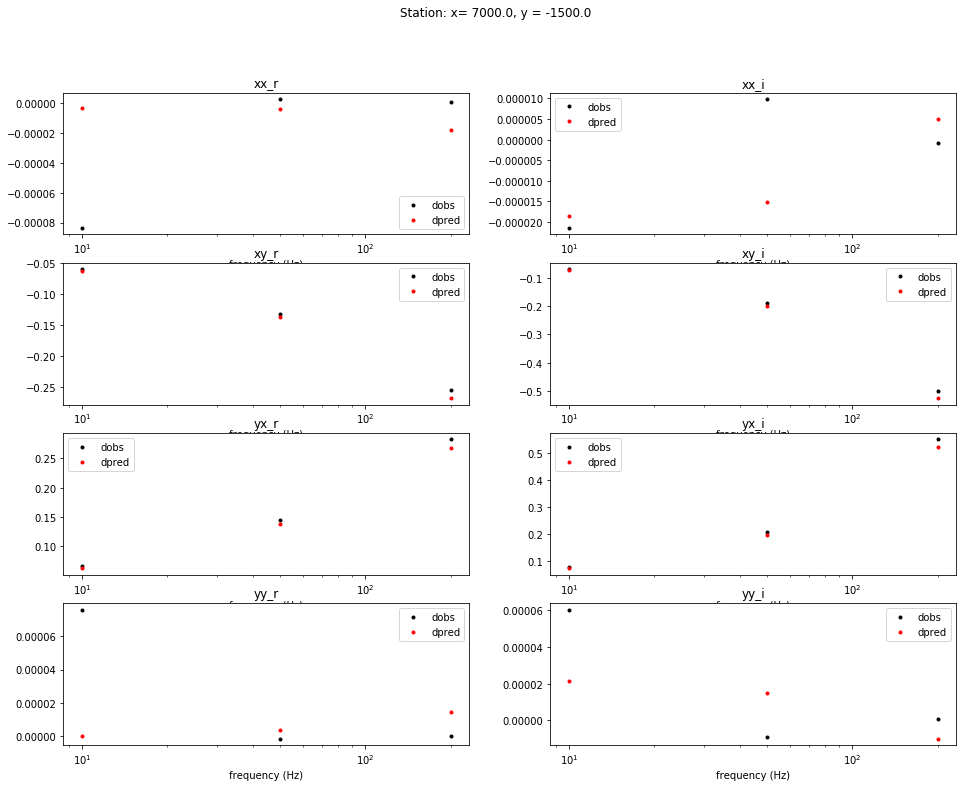

In [25]:
# plot dpred & dobs for specific station - checking fit of each frequency for a station
num_sets = int(survey.dobs.shape[0] / 3.)
dnew = np.reshape(survey.dobs, (3, num_sets))
dpred_new = np.reshape(invProb.dpred, (3, num_sets))
d_wd = dmis.W.diagonal()
Wd_new = np.reshape(d_wd, (3, num_sets))
# set station ID
stn_id = 800
location_id = rx_loc[stn_id, :]
plt.figure(figsize=(16, 12))
plt.suptitle('Station: x= {0}, y = {1}'.format(location_id[0], location_id[1]))
cnt = 0
for rx_orientation in ['xx_r', 'xx_i', 'xy_r', 'xy_i', 'yx_r', 'yx_i', 'yy_r', 'yy_i']:
    ax = plt.subplot(4,2, cnt + 1)
    ax.semilogx(survey.freqs, dnew[:, stn_id + int(cnt * num_station)], '.k')
    ax.semilogx(survey.freqs, dpred_new[:, stn_id + int(cnt * num_station)], '.r')
    ax.set_title(rx_orientation)
    ax.legend(['dobs', 'dpred'])
    ax.set_xlabel('frequency (Hz)')
    cnt += 1

plt.show()

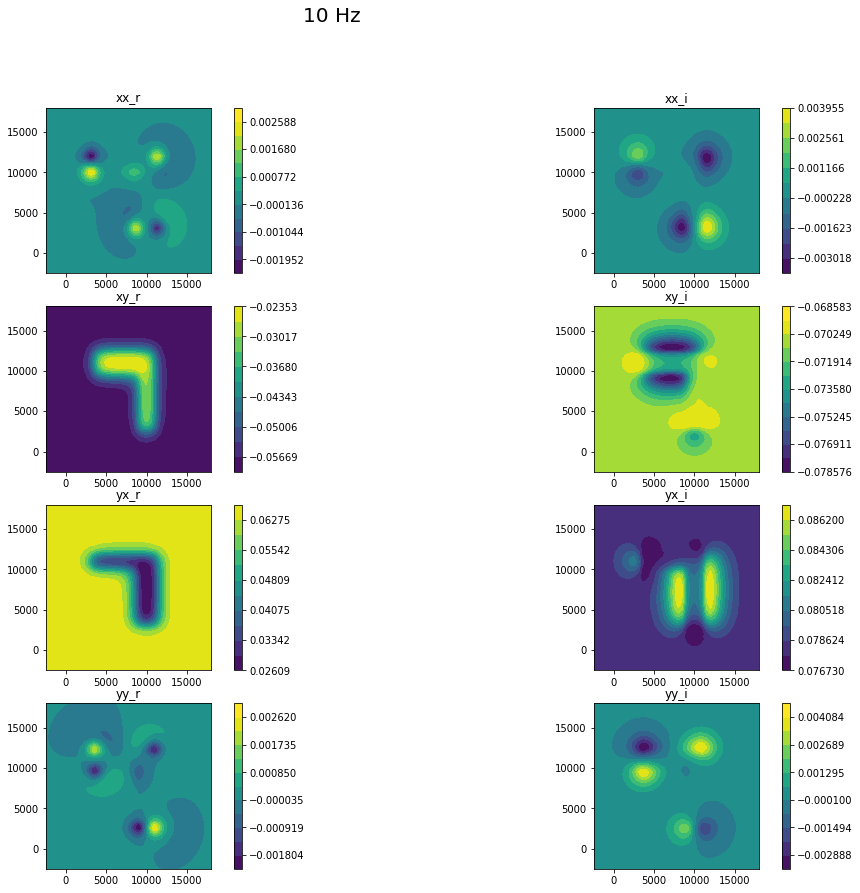

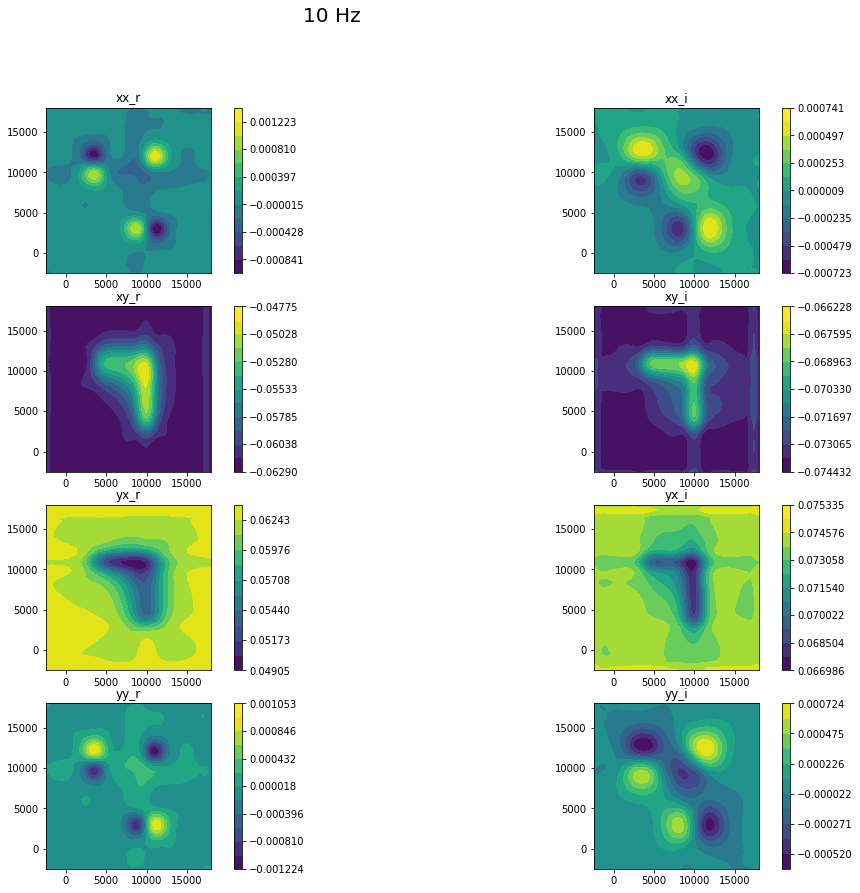

In [26]:
# plotting residual maps
freqs = ['10', '50', '200']
cnt = 0
cnt_comp = 0
comps_ = ['xx_r', 'xx_i', 'xy_r', 'xy_i', 'yx_r', 'yx_i', 'yy_r', 'yy_i']
fig1 = plt.figure(figsize=(18, 14))
for rx_orientation in range(len(comps_)):
    ax = plt.subplot(4,2, cnt_comp + 1)
    im = simpeg.utils.PlotUtils.plot2Ddata(rx_loc, dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)], ax=ax)
    ax.set_title(comps_[rx_orientation])
    plt.colorbar(im[0])
    cnt_comp += 1
fig1.suptitle(freqs[cnt] + ' Hz', fontsize='20')
plt.show()

# plotting residual maps
fig2 = plt.figure(figsize=(18, 14))
cnt_comp = 0
for rx_orientation in range(len(comps_)):
    ax = plt.subplot(4,2, cnt_comp + 1)
    im = simpeg.utils.PlotUtils.plot2Ddata(rx_loc, dpred_new[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)], ax=ax)
    ax.set_title(comps_[rx_orientation])
    plt.colorbar(im[0])
    cnt_comp += 1
fig2.suptitle(freqs[cnt] + ' Hz', fontsize='20')
plt.show()

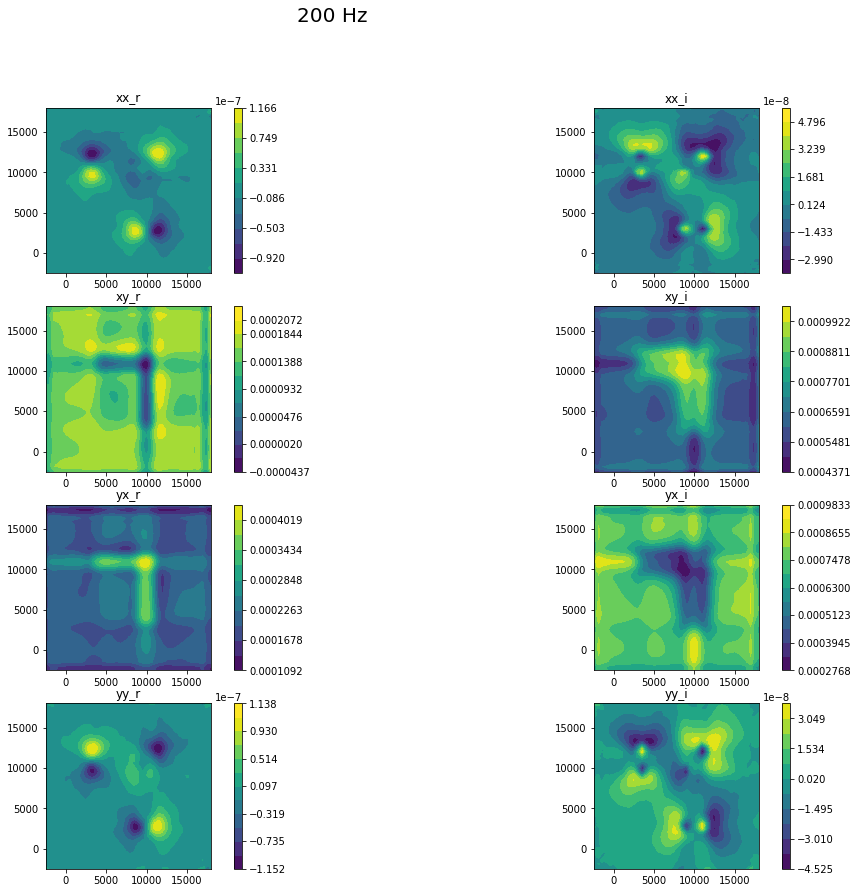

In [27]:
# plotting residual maps
freqs = ['10', '50', '200']
cnt = 2
cnt_comp = 0
comps_ = ['xx_r', 'xx_i', 'xy_r', 'xy_i', 'yx_r', 'yx_i', 'yy_r', 'yy_i']
fig1 = plt.figure(figsize=(18, 14))
for rx_orientation in range(len(comps_)):
    ax = plt.subplot(4,2, cnt_comp + 1)
    residual = (dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] -
                dpred_new[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)]) / Wd_new[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)]
    im = simpeg.utils.PlotUtils.plot2Ddata(rx_loc, residual, ax=ax)
    ax.set_title(comps_[rx_orientation])
    plt.colorbar(im[0])
    cnt_comp += 1
fig1.suptitle(freqs[cnt] + ' Hz', fontsize='20')
plt.show()

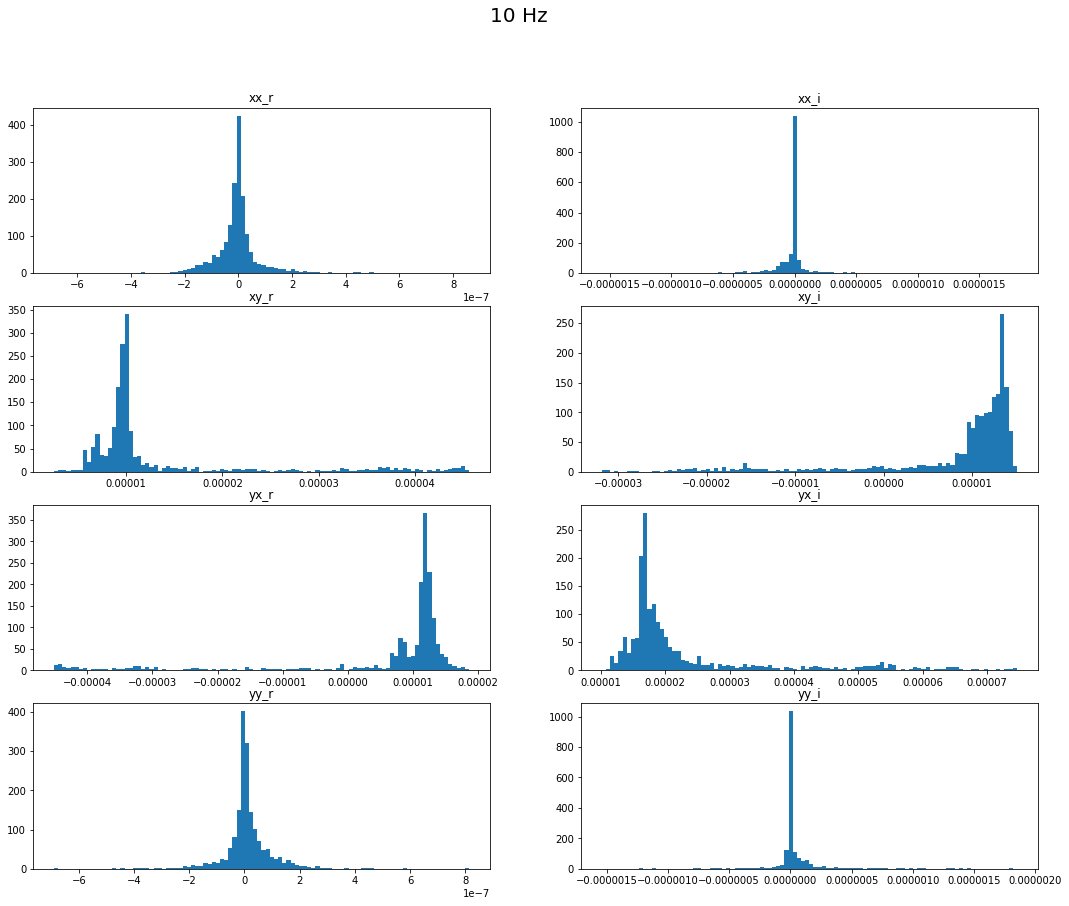

In [28]:
# plotting residual histograms
cnt = 0
cnt_comp = 0
comps_ = ['xx_r', 'xx_i', 'xy_r', 'xy_i', 'yx_r', 'yx_i', 'yy_r', 'yy_i']
fig = plt.figure(figsize=(18, 14))
for rx_orientation in range(len(comps_)):
    ax = plt.subplot(4,2, cnt_comp + 1)
    residual = (dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] -
                dpred_new[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)]) / Wd_new[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)]
    ax.hist(residual, 100)
    ax.set_title(comps_[rx_orientation])
    cnt_comp += 1
fig.suptitle(freqs[cnt] + ' Hz', fontsize='20')
plt.show()

In [16]:
np.save('Lbv2-fdata.npy', survey.dobs)
np.save('Lbv2-dpred.npy', invProb.dpred)
np.save('Lbv2-dmis.npy', d_wd)